In [26]:
import os
from collections import defaultdict
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


# 解释代码
# 数据加载：使用Surprise内置的数据集ml-100k，这是一个包含10万条电影评分记录的标准数据集。
# 数据划分：将数据划分为训练集和测试集。
# 算法选择：使用基于物品的协同过滤算法（KNNBasic），相似度度量采用余弦相似度。
# 训练模型：在训练集上训练模型。
# 预测评分：在测试集上进行预测，并计算RMSE（均方根误差）评估模型性能。
# 推荐电影：为每个用户推荐评分最高的前N部电影。
# 这样，你可以利用Surprise库方便地实现和评估推荐系统，而无需从头编写算法逻辑。如果需要处理自己的数据集，可以使用Reader类加载数据，格式如下：

def get_top_n_recommendations(predictions, n=10):
    """为每个用户推荐前N个电影"""
    # 将预测结果整理成{uid: [(iid, est), ...]}的形式
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # 对每个用户的预测评分进行排序，并返回前N个结果
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n


def get_user_recommendations(predictions, user_id, n=10):
    """为指定用户推荐前N个"""
    # 将预测结果整理成{uid: [(iid, est), ...]}的形式
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if uid == user_id:
            top_n[uid].append((iid, est))
    # uid: 用户ID
    # iid: 产品ID（或物品ID）
    # true_r: 实际评分（如果存在的话，用于评估模型的准确性）
    # est: 预测评分（模型预测的评分值）
    # _: 其他信息（通常是一个占位符，可能包括时间戳或其他元数据）

    # 对每个用户的预测评分进行排序，并返回前N个结果
    # for uid, user_ratings in top_n.items():
    #     user_ratings.sort(key=lambda x: x[1], reverse=True)
    #     top_n[uid] = user_ratings[:n]
    # return top_n

    if user_id in top_n:
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        return user_ratings[:n]
    else:
        return []

In [27]:
# 加载内置的MovieLens 100k数据集
# data = Dataset.load_builtin('ml-100k')

# 读取自己的数据集
# 定义文件格式：line_format='user item rating timestamp' 是 Surprise 库中 Reader 类的参数之一，
# 用于定义数据文件中每一行的格式。这意味着数据文件中的每一行包含四个字段，依次为 user（用户ID）、item（物品ID）、rating（评分）和 timestamp（时间戳）。
# 这些字段的顺序和名称告诉 Surprise 如何解析数据文件中的每一行。
reader = Reader(line_format='user item rating', sep='::')
# 从文件加载数据
# rating_file = os.path.join('file', 'output.dat')
rating_file = '../file/output3.dat'
print(rating_file)
data = Dataset.load_from_file(rating_file, reader=reader)

# 划分训练集和测试集
trainset, testset = train_test_split(data, test_size=0.25)

# >>>>>>计算物品相似度-s
# 基于物品的协同过滤算法
sim_options = {
    'name': 'cosine',  # 使用余弦相似度
    'user_based': False  # False表示基于物品的协同过滤
}
# KNNWithMeans：这个算法在计算相似度时，会考虑评分的平均值。也就是说，它会减去用户或物品的平均评分，然后再计算相似度。这有助于减少评分的偏差，从而使得推荐更加准确。
# KNNBasic：这是最基本的KNN算法，直接计算用户或物品之间的相似度，而不考虑评分的平均值。这种方法可能会受到评分偏差的影响。
# algo = KNNBasic(sim_options=sim_options)

# 使用 SVD 算法，n_factors 潜在特征的数目
# algo = SVD(n_factors=12)
algo = SVD(n_factors=60, lr_all=0.007, reg_all=0.02)

# 训练模型
# algo.fit(trainset)
algo.fit(data.build_full_trainset())
# >>>>>>计算物品相似度-e

# 在测试集上进行预测，预测的结果也可以用于实际推荐。
# testset 通常是从数据集中分割出的测试集，包含用户-物品对和对应的实际评分。它用于比较模型的预测评分和真实评分，以计算误差（如 RMSE）。
predictions = algo.test(testset)

# >>>>>>评估模型-s
# 评估模型的准确性
accuracy.rmse(predictions)

# 在训练集上进行预测
# trainset.build_testset() 用于生成一个与训练集结构相同但评分未知的测试集。它主要用于生成模型预测的输入数据。
# 生成的测试集是一个包含所有用户-物品对的列表，其中每个对的评分字段为 None 或者一个占位符值。
# 这些数据对通常用来生成预测评分，而不是用来评估模型性能。
train_predictions = algo.test(trainset.build_testset())
# train_predictions = algo.test(trainset.build_full_trainset())

../file/output3.dat
RMSE: 0.5630


In [31]:
# 指定用户ID
# 指定用户的推荐结果
specified_user_id = '11290391'
top_n = get_user_recommendations(train_predictions, specified_user_id, n=10)

# >>>>>>推荐算法-s
# 获取推荐结果
# top_n = get_top_n_recommendations(predictions, n=2)
# top_n = get_top_n_recommendations(train_predictions, n=2)

In [33]:
all_top_n = get_top_n_recommendations(train_predictions)
all_top_n

defaultdict(list,
            {'12156189': [('31189', 1.0601723233383469),
              ('12578', 1.0425535553748437),
              ('17107', 1.0060853064192345),
              ('45827', 1.0000615586266717),
              ('25184', 1),
              ('46367', 1),
              ('44444', 1),
              ('43738', 1),
              ('46492', 1),
              ('44584', 1)],
             '10769047': [('19318', 2.146037382139848),
              ('42487', 2.0499361185518996),
              ('40402', 2.0413250732744377),
              ('15226', 2.0291590271407878),
              ('36560', 2.0214032250289002),
              ('18844', 2.019762966528816),
              ('15467', 2.0116022008263776),
              ('39110', 2.004144054980806),
              ('10437', 1.9953852215367576),
              ('17448', 1.9820169478148257)],
             '10522197': [('26471', 1.8427144234587987),
              ('46168', 1.7990770257878037),
              ('12578', 1.7845427940070797),
              

In [23]:
# 打印推荐结果
for uid, user_ratings in top_n.items():
    print(f"User ——> {uid}:")
    for (iid, est) in user_ratings:
        print(f"  推荐 {iid}: 预测评分 {est}")

AttributeError: 'list' object has no attribute 'items'

In [32]:
# 打印推荐结果
print(f"Top {len(top_n)} recommendations for user {specified_user_id}:")
for iid, est in top_n:
    print(f"  推荐 {iid}: 预测评分 {est}")

Top 10 recommendations for user 11290391:
  推荐 40276: 预测评分 1
  推荐 18673: 预测评分 1
  推荐 44008: 预测评分 1
  推荐 30065: 预测评分 1
  推荐 30146: 预测评分 1
  推荐 20108: 预测评分 1
  推荐 36930: 预测评分 1
  推荐 33917: 预测评分 1
  推荐 20380: 预测评分 1
  推荐 36819: 预测评分 1


In [11]:
train_predictions

[Prediction(uid='11301388', iid='37236', r_ui=4.12, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='21372', r_ui=6.09, est=4.825170605217448, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='19676', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='17232', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='15446', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='11773', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='15150', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='35092', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='39889', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='34068', r_ui=6.09, est=5, details={'was_impossible': False}),
 Prediction(uid='11301388', iid='2

In [12]:
for uid, iid, true_r, est, _ in predictions:
    if uid == specified_user_id:
        print(uid, iid, true_r, est)

10828263 16330 1.59 2.972992877549823
10828263 15150 1.59 3.0290020786491887


In [ ]:
# 查看用户10828263在训练集中的交互记录数
user_interactions = trainset.ur[trainset.to_inner_uid(specified_user_id)]
print(f"User {specified_user_id} has {len(user_interactions)} interactions in the training set.")

1. 网格搜索（Grid Search）
网格搜索是一种系统地遍历多个参数组合的方法。Surprise库提供了GridSearchCV，可以用来找到最优的 n_factors 值。

In [20]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'n_factors': [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100],
    'lr_all': [0.002, 0.005, 0.007],
    'reg_all': [0.02, 0.05, 0.1]
}

# 使用网格搜索找到最优的参数
# cv=5 中的 5 是交叉验证中折的数量，代表将数据分成5个子集。选择合适的折数对模型的评估和选择非常重要。
# 交叉验证是一种评估模型性能的方法，通过将数据集分成多个子集来进行训练和测试。常见的方法是 K 折交叉验证（K-fold cross-validation），
# 其中 K 代表数据被分成的子集（折）的数量。
# 在实践中，cv=5 和 cv=10 是最常用的选择，因为它们在计算成本和评估稳定性之间提供了良好的平衡。经验表明，这两个值通常能提供足够准确的模型性能评估。
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
data = Dataset.load_from_file(rating_file, reader=reader)
gs.fit(data)

# 输出最优参数
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE score: 0.617215660249238
Best parameters: {'n_factors': 60, 'lr_all': 0.007, 'reg_all': 0.02}


2. 随机搜索（Random Search）
随机搜索是一种随机选择参数组合的方法，适用于参数空间较大时。

In [6]:
from surprise import SVD
from surprise.model_selection import RandomizedSearchCV

# 定义参数分布
param_distributions = {
    'n_factors': [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100],
    'lr_all': [0.002, 0.005, 0.007],
    'reg_all': [0.02, 0.05, 0.1]
}

# 使用随机搜索找到最优的参数
rs = RandomizedSearchCV(SVD, param_distributions, measures=['rmse'], cv=5, n_iter=20)
rs.fit(data)

# 输出最优参数
print(f"Best RMSE score: {rs.best_score['rmse']}")
print(f"Best parameters: {rs.best_params['rmse']}")


Best RMSE score: 0.8955028819935137
Best parameters: {'n_factors': 20, 'lr_all': 0.007, 'reg_all': 0.02}


3. 手动调参
手动调参是逐步调整 n_factors 并评估模型性能的方法。这种方法直观但较为耗时。

In [ ]:
import numpy as np
from surprise import SVD
from surprise.model_selection import cross_validate

# 定义候选的 n_factors 值
n_factors_list = [5, 10, 20, 50, 100]

for n_factors in n_factors_list:
    algo = SVD(n_factors=n_factors)
    # 进行交叉验证
    cv_results = cross_validate(algo, data, measures=['rmse'], cv=5, verbose=True)
    print(f"n_factors: {n_factors}, Mean RMSE: {np.mean(cv_results['test_rmse'])}")


4. 可视化方法
通过可视化的方式找到最佳 n_factors。下面的例子展示了如何绘制 n_factors 与 RMSE 之间的关系图。

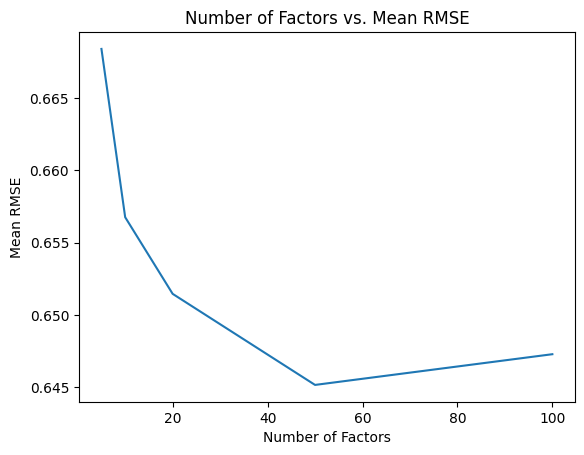

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from surprise.model_selection import cross_validate

n_factors_list = [5, 10, 20, 50, 100]
mean_rmse = []

for n_factors in n_factors_list:
    algo = SVD(n_factors=n_factors)
    cv_results = cross_validate(algo, data, measures=['rmse'], cv=5, verbose=False)
    mean_rmse.append(np.mean(cv_results['test_rmse']))

plt.plot(n_factors_list, mean_rmse)
plt.xlabel('Number of Factors')
plt.ylabel('Mean RMSE')
plt.title('Number of Factors vs. Mean RMSE')
plt.show()

从你的图表可以看到，随着潜在特征（因子）的数量增加，均方根误差（RMSE）先降低后趋于平稳甚至略有上升。这表明在某个点之后，增加因子的数量不会显著提高模型的性能，反而可能导致过拟合。

确定因子数量的步骤
绘制因子数量 vs. 均方根误差的曲线：

你已经完成了这一步，从图中可以看到RMSE随因子数量变化的趋势。
找到曲线的拐点：

通常，曲线的拐点或趋于平稳的点是最佳的因子数量。这是因为在拐点之后，增加因子数量对RMSE的改进变得微乎其微甚至无效。
从你的图中看，最佳因子数量大约在30到50之间，具体的拐点在40左右。

lr_all 和 reg_all 是 SVD 算法的超参数，用于控制模型的学习过程和防止过拟合。以下是对这些参数的详细解释：

n_factors
解释: 表示潜在特征的数量，即用户和物品隐含特征向量的维度。
作用: 增加 n_factors 值可以捕捉到更多的潜在特征，但也可能导致过拟合。较小的值可能无法充分表达数据中的复杂模式。
lr_all
解释: 学习率（learning rate），控制每次梯度更新的步长。
作用: 较大的学习率会加快训练速度，但可能导致训练不稳定和震荡；较小的学习率会使训练更稳定，但需要更多的迭代次数。
reg_all
解释: 正则化参数（regularization term），用于防止过拟合。
作用: 较大的正则化参数可以减少过拟合，但可能会增加偏差；较小的正则化参数可能会导致模型过拟合训练数据。

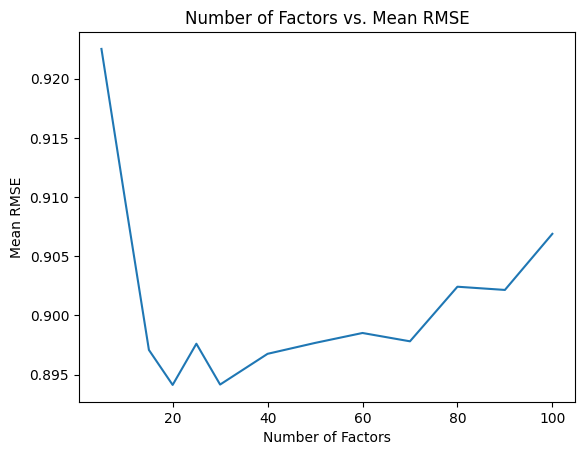

Optimal number of factors: 20


In [9]:
import matplotlib.pyplot as plt
from surprise import SVD
from surprise.model_selection import cross_validate

# 设置不同的因子数量
factors = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
rmse_values = []

# 计算每个因子数量对应的 RMSE
for factor in factors:
    algo = SVD(n_factors=factor, lr_all=0.007, reg_all=0.02)
    cv_results = cross_validate(algo, data, measures=['rmse'], cv=5, verbose=False)
    rmse_values.append(cv_results['test_rmse'].mean())

# 绘制因子数量 vs. 均方根误差的曲线
plt.plot(factors, rmse_values)
plt.xlabel('Number of Factors')
plt.ylabel('Mean RMSE')
plt.title('Number of Factors vs. Mean RMSE')
plt.show()

# 打印最佳因子数量
optimal_factors = factors[rmse_values.index(min(rmse_values))]
print(f"Optimal number of factors: {optimal_factors}")


In [ ]:
import redis
from collections import defaultdict
from surprise import Dataset, Reader, SVD

# 初始化 Redis 缓存
cache = redis.Redis(host='192.168.22.238', port=6379, db=0)

# 加载数据和训练模型
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)


def precompute_recommendations():
    """预计算所有用户的推荐结果并存储在缓存中"""
    all_predictions = algo.test(trainset.build_testset())
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in all_predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        # 存储在缓存中
        cache.set(uid, str(user_ratings[:10]))  # 存储前10个推荐


def get_recommendations(user_id):
    """从缓存中获取推荐结果"""
    recommendations = cache.get(user_id)
    if recommendations:
        return eval(recommendations)
    else:
        # 如果缓存中没有，进行实时计算并缓存结果
        # 生成反向测试集
        testset = trainset.build_anti_testset(fill=0)
        predictions = algo.test(testset)
        user_ratings = [pred for pred in predictions if pred[0] == user_id]
        user_ratings.sort(key=lambda x: x[3], reverse=True)
        cache.set(user_id, str(user_ratings[:10]))
        return user_ratings[:10]


# 预计算所有用户的推荐结果
precompute_recommendations()

In [14]:
# 获取指定用户的推荐结果
user_id = '1350292'
recommendations = get_recommendations(user_id)
print(f"Recommendations for user {user_id}: {recommendations}")

Recommendations for user 1350292: [('33176', 2.74759250039319), ('36819', 1.9636872646625352)]
